# Wikipedia Web Traffic Data

The dataset is available [on Kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data)

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Imports and reading data

We read the data and fill any non-existing values with 0, representing 0 views for the specific page on that day.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import re
from statsmodels.tsa.arima_model import ARIMA
from dtaidistance import dtw
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
import holidays
from sklearn import preprocessing
import time
import tsfresh

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
original_dataset = pd.read_csv("data/train_2.csv")
original_dataset.info()
original_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


Page  2015-07-01  2015-07-02  2015-07-03     ...      2017-09-07  2017-09-08  2017-09-09  2017-09-10
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0         5.0     ...            29.0        23.0        54.0        38.0
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0        15.0     ...            26.0        23.0        13.0        81.0
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0         1.0     ...             3.0         4.0         7.0         6.0
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0        10.0     ...            19.0        30.0        38.0         4.0
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN         NaN     ...            28.0        14.0         8.0         7.0

[5 rows x 804 columns]

## Removing all rows with NaN

In [4]:
original_dataset.dropna(axis='index',inplace=True)
original_dataset.reset_index(inplace=True,drop=True)
original_dataset.info()
original_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115084 entries, 0 to 115083
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 705.9+ MB


Page  2015-07-01  2015-07-02  2015-07-03     ...      2017-09-07  2017-09-08  2017-09-09  2017-09-10
0     2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0         5.0     ...            29.0        23.0        54.0        38.0
1      2PM_zh.wikipedia.org_all-access_spider        11.0        14.0        15.0     ...            26.0        23.0        13.0        81.0
2       3C_zh.wikipedia.org_all-access_spider         1.0         0.0         1.0     ...             3.0         4.0         7.0         6.0
3  4minute_zh.wikipedia.org_all-access_spider        35.0        13.0        10.0     ...            19.0        30.0        38.0         4.0
4     5566_zh.wikipedia.org_all-access_spider        12.0         7.0         4.0     ...            18.0        17.0        14.0        11.0

[5 rows x 804 columns]

## Visualising some series

In [5]:
def plot_series(series, title, new_plot = True, plot_show = True, label = None, color='blue'):
    if new_plot:
        plt.figure(figsize=(20,10))
    days = range(series.shape[0])
    plt.plot(days,series,label=label, color=color)
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Views")
    if plot_show:
        plt.legend()
        plt.show()

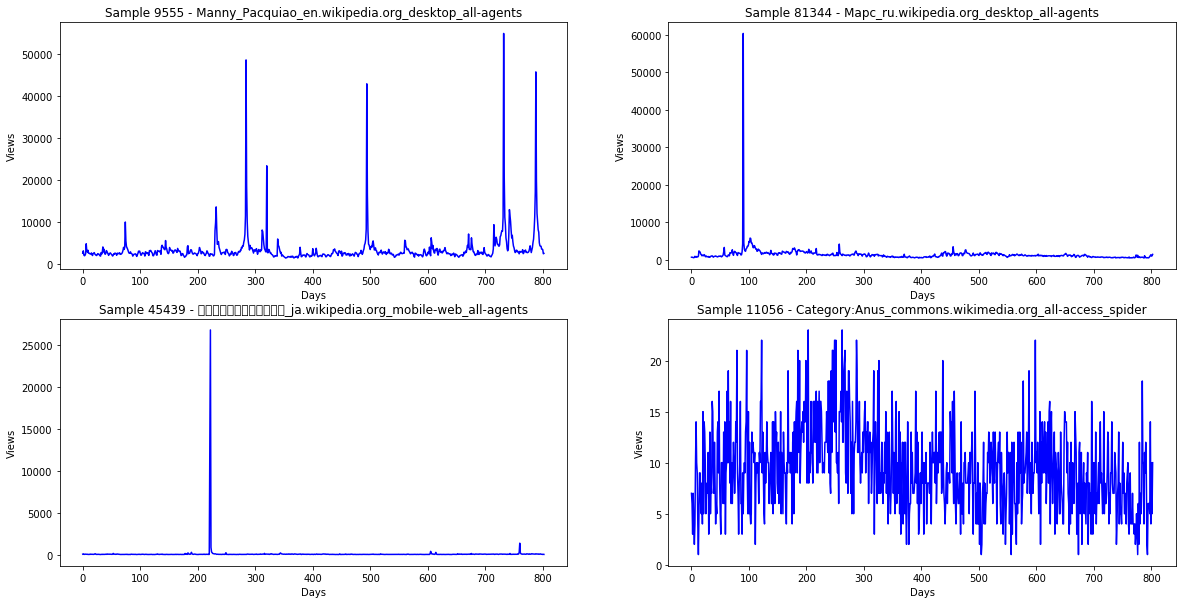

In [6]:
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    sample = random.randint(0,original_dataset.shape[0])
    data = original_dataset.iloc[sample,1:]
    plot_series(data,f"Sample {sample} - {original_dataset.iloc[sample,0]}",new_plot=False,plot_show=False)
plt.show()

## Extracting metadata

Here, we take the compound page name and extract the name of the article, the language, the type of access and the agent for each page.

In [7]:
def extract_meta(page):
    parts = page.split("_")
    [project,access,agent] = parts[-3:]
    name = " ".join(parts[0:-3])
    match_lang = re.search("([a-z][a-z])\.wikipedia\.org",project)
    lang = match_lang.group(1) if match_lang else 'na'
    return [name,lang,access,agent]

In [8]:
meta_dataset = original_dataset.copy()
meta_dataset['name'],  meta_dataset['lang'], meta_dataset['access'], meta_dataset['agent'] = zip(*meta_dataset['Page'].apply(extract_meta))
meta_dataset = meta_dataset[['Page', 'name', 'lang', 'access', 'agent'] + [c for c in meta_dataset if c not in ['Page', 'name', 'lang', 'access', 'agent']]]

In [9]:
print(meta_dataset['agent'].unique())
print(meta_dataset['access'].unique())

['spider' 'all-agents']
['all-access' 'desktop' 'mobile-web']


In [10]:
meta_dataset.head()

Page     name lang      access   agent     ...      2017-09-06  2017-09-07  2017-09-08  2017-09-09  2017-09-10
0     2NE1_zh.wikipedia.org_all-access_spider     2NE1   zh  all-access  spider     ...            27.0        29.0        23.0        54.0        38.0
1      2PM_zh.wikipedia.org_all-access_spider      2PM   zh  all-access  spider     ...            25.0        26.0        23.0        13.0        81.0
2       3C_zh.wikipedia.org_all-access_spider       3C   zh  all-access  spider     ...             7.0         3.0         4.0         7.0         6.0
3  4minute_zh.wikipedia.org_all-access_spider  4minute   zh  all-access  spider     ...            16.0        19.0        30.0        38.0         4.0
4     5566_zh.wikipedia.org_all-access_spider     5566   zh  all-access  spider     ...            20.0        18.0        17.0        14.0        11.0

[5 rows x 808 columns]

## Splitting data

In [11]:
training_days = 365+366
features_dataset = meta_dataset.iloc[:,5:]
meta_dataset = meta_dataset.iloc[:,:5]
train_dataset = features_dataset.iloc[:,:training_days]
test_dataset = features_dataset.iloc[:,training_days:]

In [12]:
meta_dataset.head()

Page     name lang      access   agent
0     2NE1_zh.wikipedia.org_all-access_spider     2NE1   zh  all-access  spider
1      2PM_zh.wikipedia.org_all-access_spider      2PM   zh  all-access  spider
2       3C_zh.wikipedia.org_all-access_spider       3C   zh  all-access  spider
3  4minute_zh.wikipedia.org_all-access_spider  4minute   zh  all-access  spider
4     5566_zh.wikipedia.org_all-access_spider     5566   zh  all-access  spider

In [13]:
train_dataset.head()

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05     ...      2017-06-26  2017-06-27  2017-06-28  2017-06-29  2017-06-30
0        18.0        11.0         5.0        13.0        14.0     ...            23.0        32.0        34.0        21.0        24.0
1        11.0        14.0        15.0        18.0        11.0     ...            62.0       127.0       104.0        20.0        29.0
2         1.0         0.0         1.0         1.0         0.0     ...             4.0         5.0         5.0         0.0         6.0
3        35.0        13.0        10.0        94.0         4.0     ...            12.0        10.0        22.0        21.0        30.0
4        12.0         7.0         4.0         5.0        20.0     ...            30.0        13.0        14.0        14.0        20.0

[5 rows x 731 columns]

In [14]:
test_dataset.head()

2017-07-01  2017-07-02  2017-07-03  2017-07-04  2017-07-05     ...      2017-09-06  2017-09-07  2017-09-08  2017-09-09  2017-09-10
0        23.0        24.0        26.0        15.0        14.0     ...            27.0        29.0        23.0        54.0        38.0
1        15.0        26.0        16.0        23.0        19.0     ...            25.0        26.0        23.0        13.0        81.0
2         1.0         1.0         7.0         1.0         1.0     ...             7.0         3.0         4.0         7.0         6.0
3         7.0        19.0        16.0        10.0        17.0     ...            16.0        19.0        30.0        38.0         4.0
4        10.0        10.0        29.0        33.0        20.0     ...            20.0        18.0        17.0        14.0        11.0

[5 rows x 72 columns]

## Clustering time series

In [15]:
min_max_scaler = preprocessing.MinMaxScaler()

train_dataset_norm = pd.DataFrame(min_max_scaler.fit_transform(train_dataset.transpose()).transpose(),columns=train_dataset.columns)

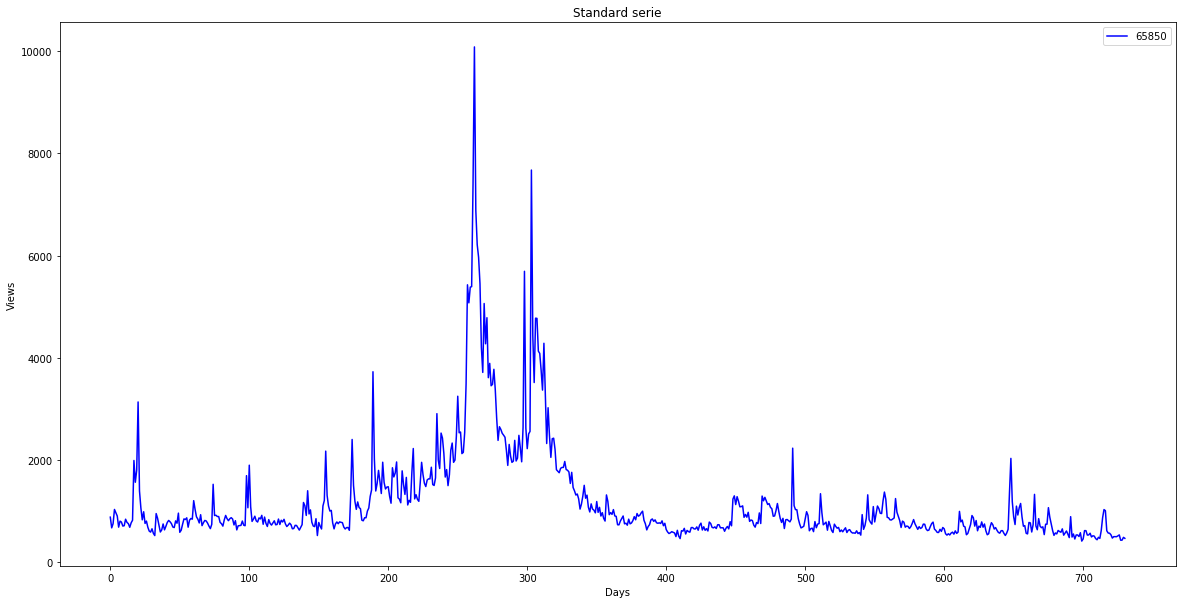

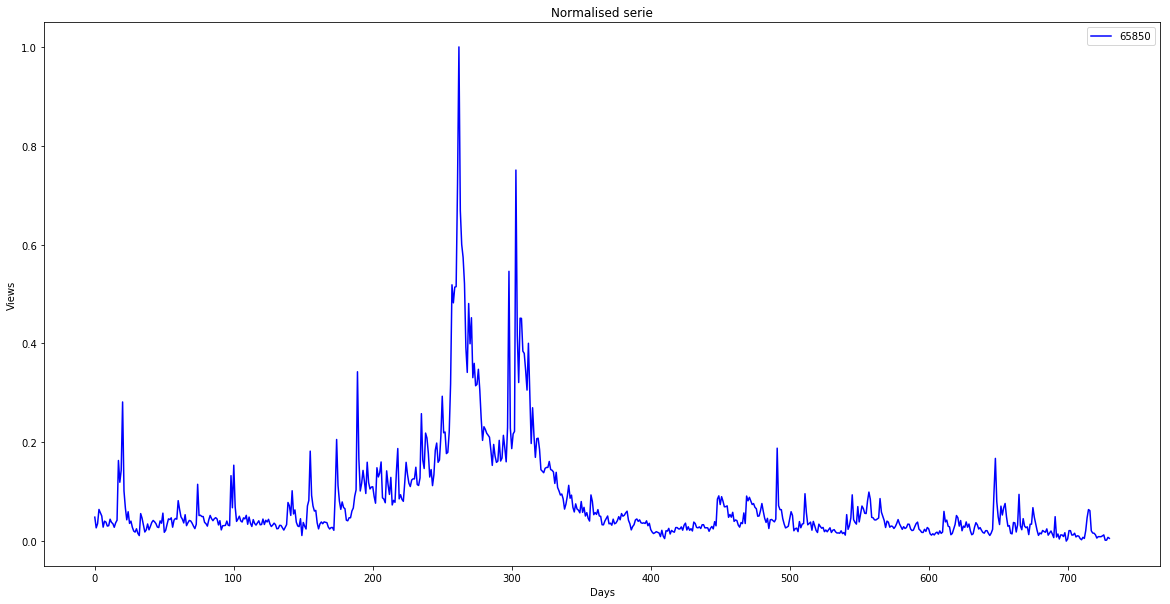

In [16]:
sample = random.randint(0,len(train_dataset))
plot_series(train_dataset.iloc[sample,:],"Standard serie")
plot_series(train_dataset_norm.iloc[sample,:],"Normalised serie")

In [17]:
std = train_dataset_norm.std(axis=1)
std

0         0.055815
1         0.050798
2         0.056325
3         0.058371
4         0.073302
5         0.094356
6         0.082702
7         0.121844
8         0.094849
9         0.118781
10        0.064783
11        0.081952
12        0.105794
13        0.048867
14        0.084055
15        0.085338
16        0.053496
17        0.097299
18        0.054140
19        0.102865
20        0.096192
21        0.062814
22        0.083086
23        0.079708
24        0.075415
25        0.067034
26        0.079173
27        0.070854
28        0.053776
29        0.044170
            ...   
115054    0.047312
115055    0.084404
115056    0.075208
115057    0.106792
115058    0.100702
115059    0.065807
115060    0.081040
115061    0.088236
115062    0.091303
115063    0.066858
115064    0.092446
115065    0.094111
115066    0.100656
115067    0.121556
115068    0.066023
115069    0.051414
115070    0.089088
115071    0.081974
115072    0.108384
115073    0.106057
115074    0.083051
115075    0.

In [18]:
buckets_std = pd.qcut(x=std,q=10,labels=False)
buckets_std

0         3
1         2
2         3
3         4
4         5
5         7
6         6
7         8
8         7
9         8
10        4
11        6
12        8
13        2
14        6
15        6
16        3
17        7
18        3
19        8
20        7
21        4
22        6
23        6
24        6
25        5
26        6
27        5
28        3
29        1
         ..
115054    2
115055    6
115056    6
115057    8
115058    7
115059    5
115060    6
115061    7
115062    7
115063    5
115064    7
115065    7
115066    7
115067    8
115068    5
115069    2
115070    7
115071    6
115072    8
115073    8
115074    6
115075    8
115076    6
115077    1
115078    0
115079    4
115080    7
115081    7
115082    7
115083    7
Length: 115084, dtype: int64

0


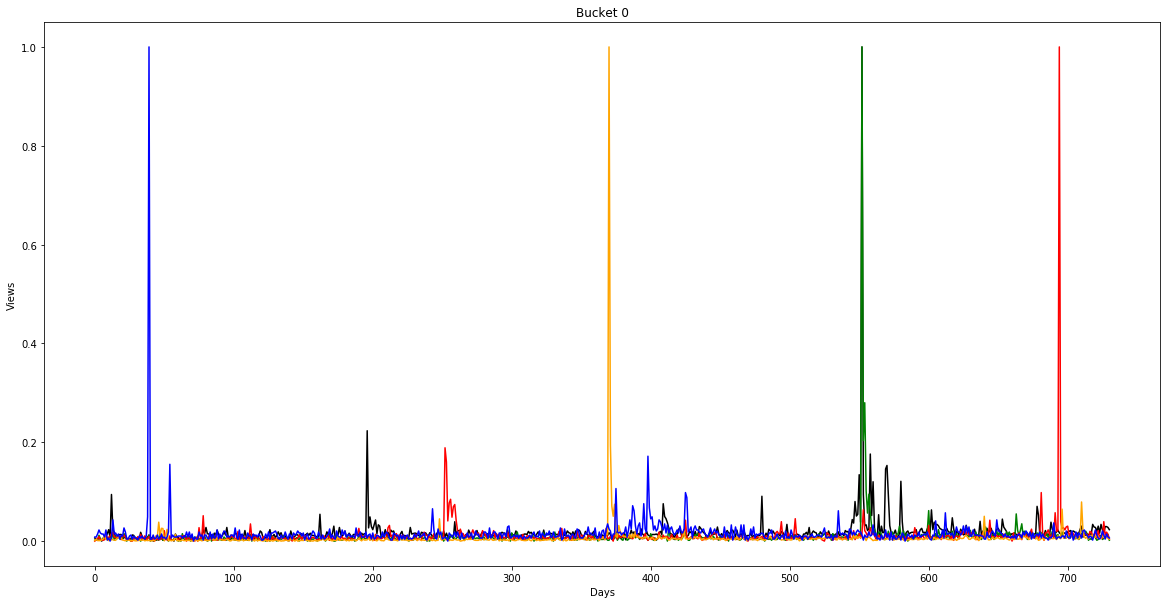

1


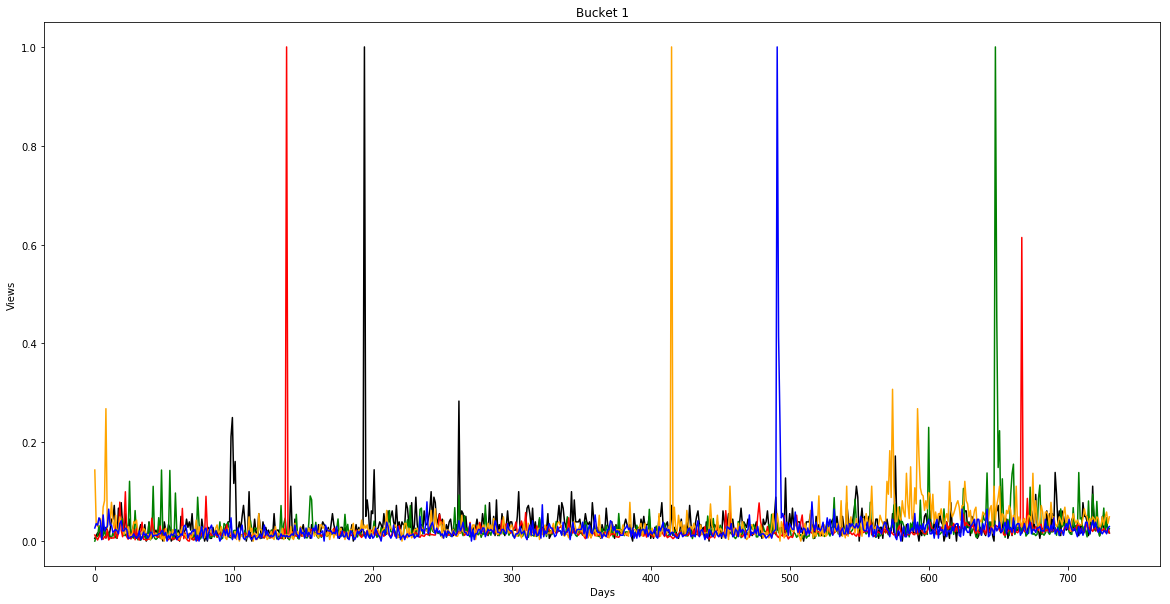

2


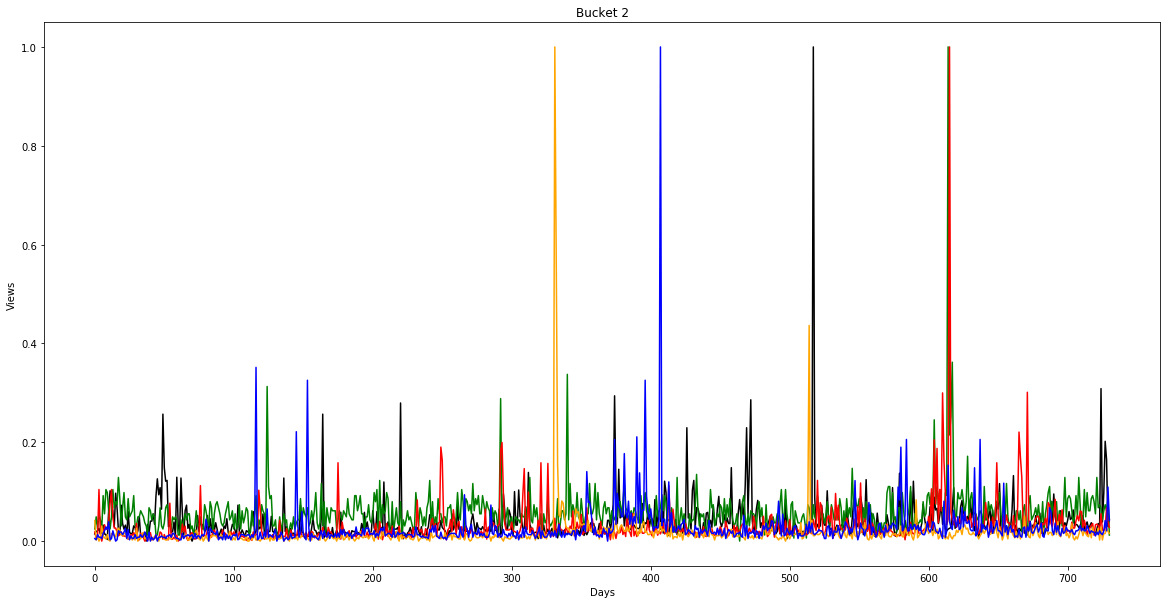

3


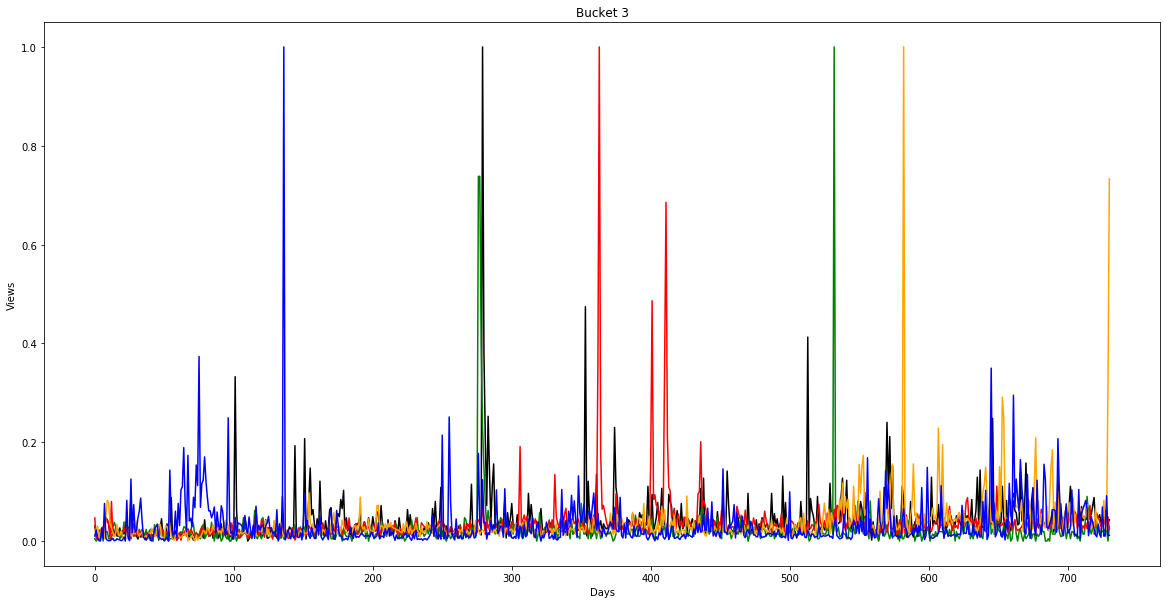

4


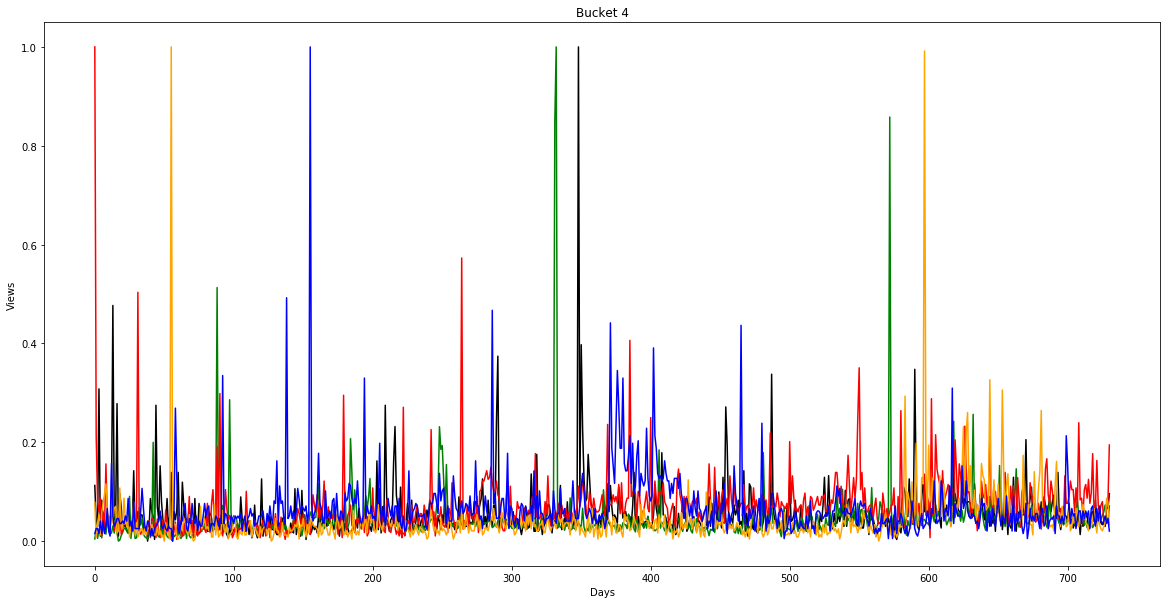

5


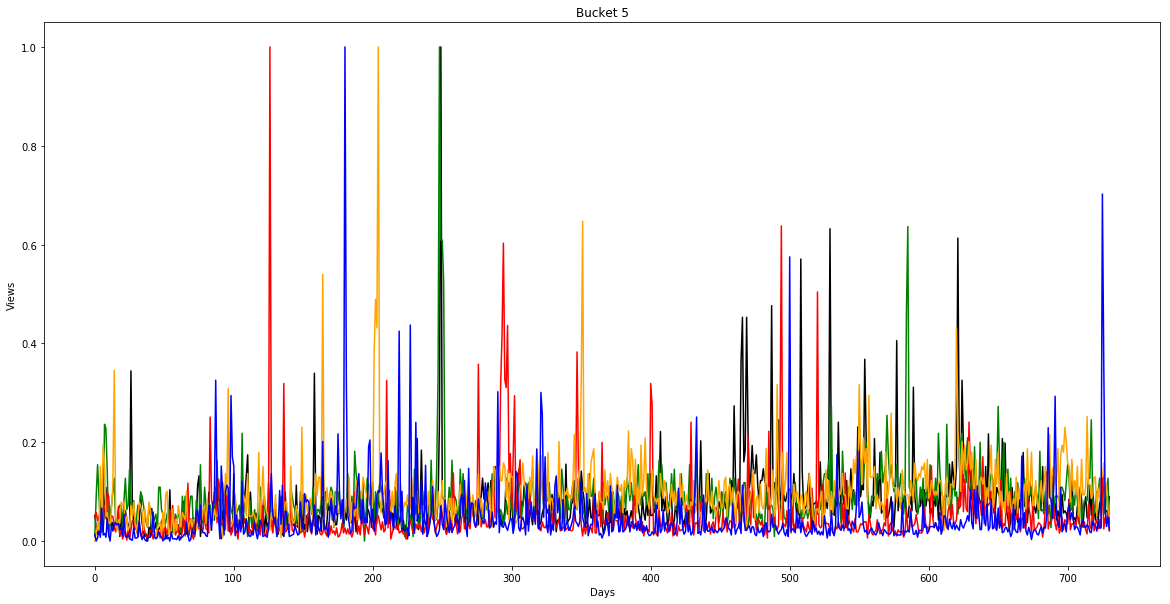

6


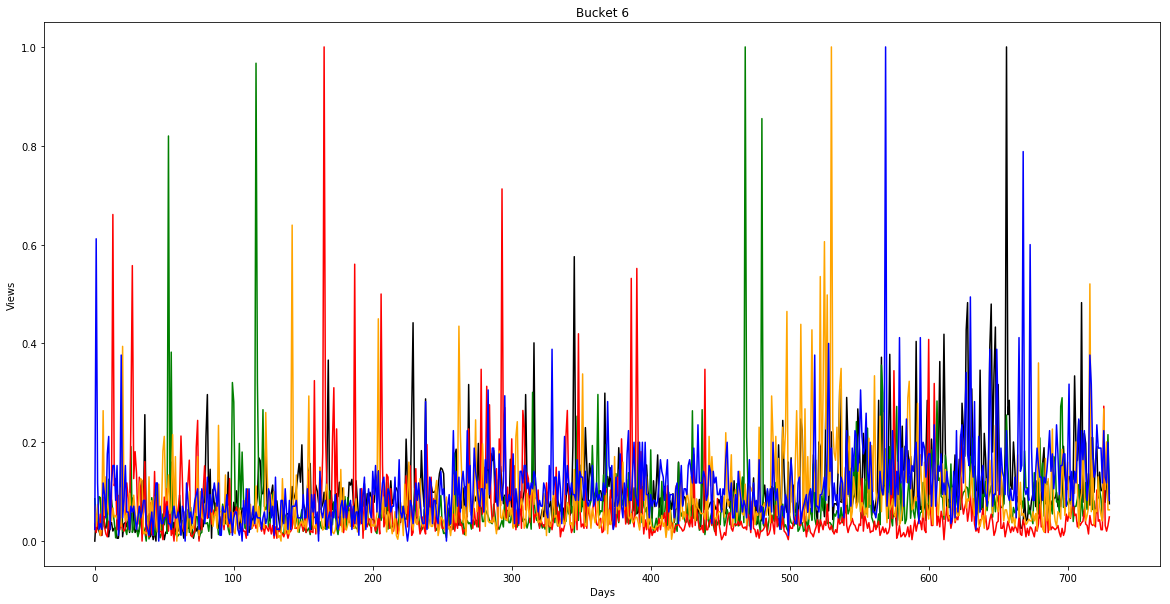

7


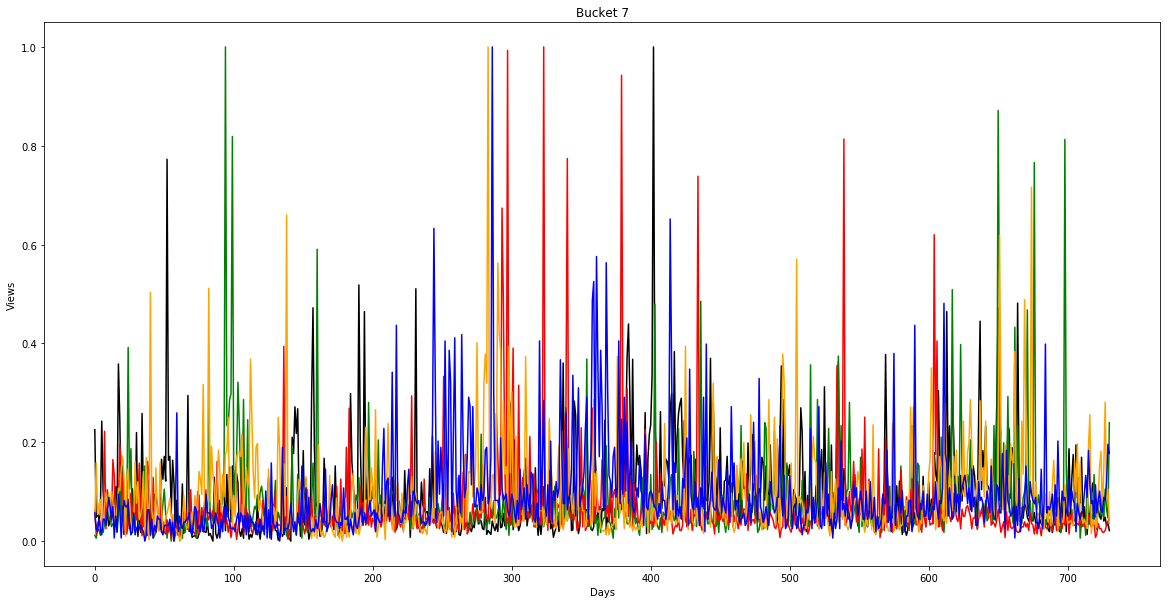

8


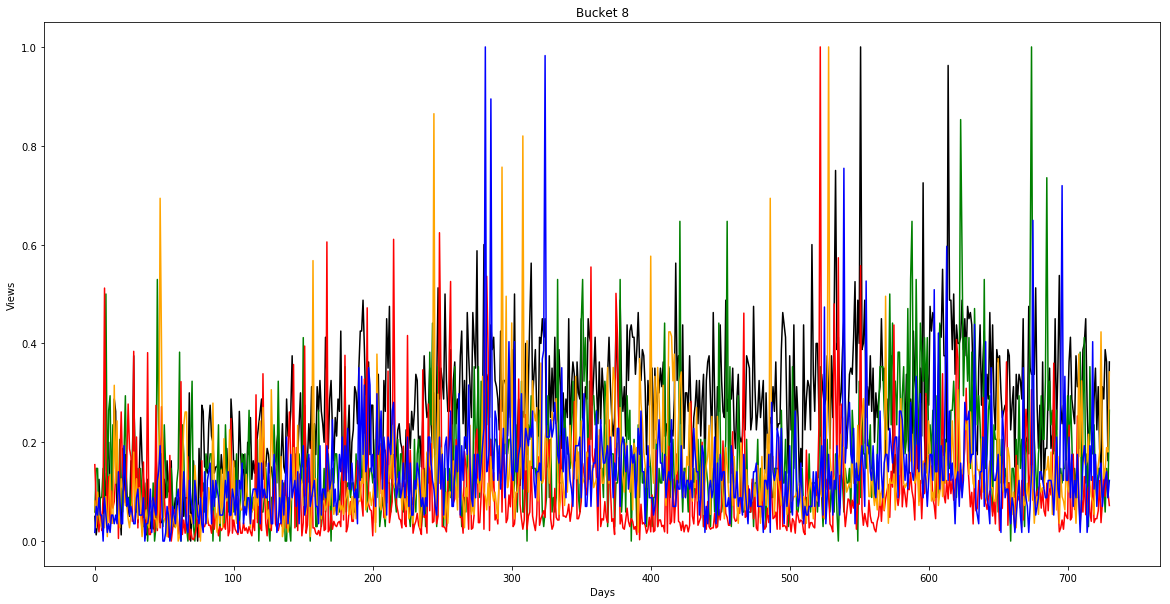

9


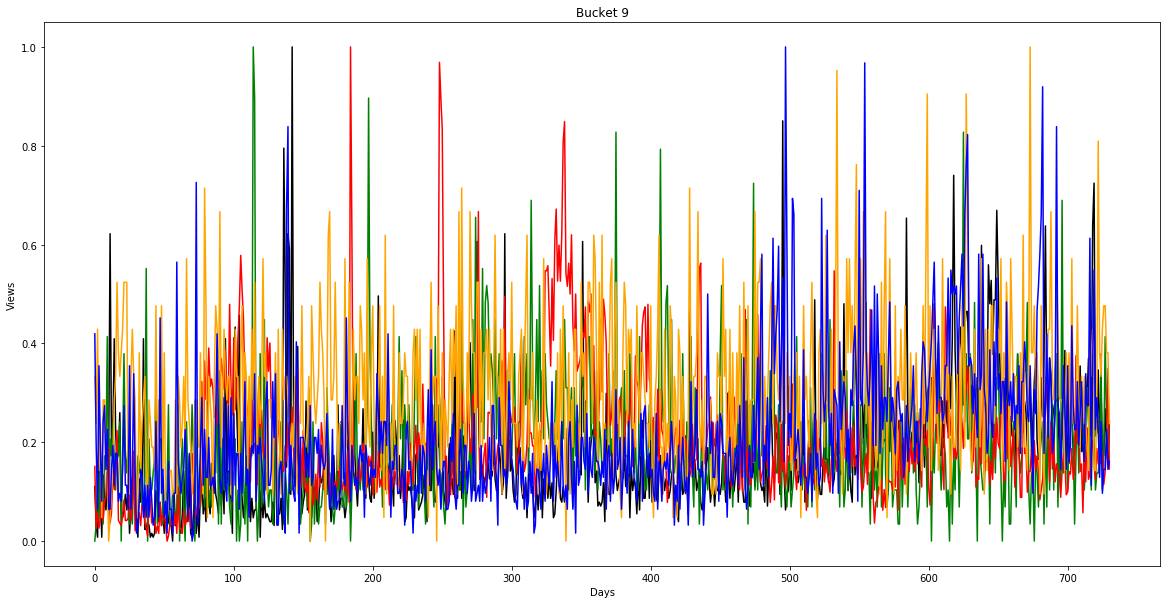

In [19]:
colors = ['black','green','red','orange','blue']
for buck in range(10):
    print(buck)
    filtered = train_dataset_norm[buckets_std == buck]
    plt.figure(figsize=(20,10))
    for sample in range(5):
        plot_series(filtered.iloc[sample,:],f"Bucket {buck}",new_plot=False,plot_show=False,color=colors[sample])
    plt.show()

In [20]:
rest_training,dtw_training,rest_buckets, dtw_buckets = train_test_split(train_dataset_norm,buckets_std,test_size=0.01,random_state=42,stratify=buckets_std)
dtw_training.info()
dtw_training.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151 entries, 1034 to 26044
Columns: 731 entries, 2015-07-01 to 2017-06-30
dtypes: float64(731)
memory usage: 6.4 MB


2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05     ...      2017-06-26  2017-06-27  2017-06-28  2017-06-29  2017-06-30
1034      0.241164    0.322245    0.266112    0.103950    0.567568     ...        0.027027    0.029106    0.043659    0.045738    0.027027
106532    0.000368    0.001103    0.000735    0.000735    0.000000     ...        0.043382    0.004779    0.005515    0.004779    0.003676
17845     0.024344    0.075364    0.032502    0.015798    0.010554     ...        0.004467    0.006539    0.003432    0.003173    0.001165
39872     0.000251    0.001656    0.000803    0.001305    0.001455     ...        0.000903    0.001656    0.001756    0.001806    0.001505
60784     0.065753    0.031507    0.061644    0.060274    0.063014     ...        0.387671    0.402740    0.404110    0.331507    0.401370

[5 rows x 731 columns]

In [21]:
buckets_unique = dtw_buckets.unique()
buckets_unique.sort()
for i in buckets_unique:
    print(f"{i} => {len(dtw_buckets[dtw_buckets == i])}")

0 => 116
1 => 115
2 => 115
3 => 115
4 => 115
5 => 115
6 => 115
7 => 115
8 => 115
9 => 115


In [22]:
dtw_training_np = dtw_training.values.astype(np.float) 
ds = dtw.distance_matrix_fast(dtw_training_np, show_progress=True)

In [23]:
for i in range(ds.shape[0]):
    for j in range(i, ds.shape[1]):
        if i == j: 
            ds[i][i] = 0
        elif i < j:
            ds[j][i] = ds[i][j]

In [24]:
print(ds)

[[0.         1.89067557 1.7608978  ... 2.1136989  1.8916372  2.24111152]
 [1.89067557 0.         0.81577345 ... 0.96242728 1.38009863 0.8918    ]
 [1.7608978  0.81577345 0.         ... 1.04931952 1.0592973  1.0102026 ]
 ...
 [2.1136989  0.96242728 1.04931952 ... 0.         1.17165996 0.99216595]
 [1.8916372  1.38009863 1.0592973  ... 1.17165996 0.         1.87810003]
 [2.24111152 0.8918     1.0102026  ... 0.99216595 1.87810003 0.        ]]


In [25]:
clustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', connectivity=ds, compute_full_tree=True, linkage='ward')
clustering.fit(ds)
clustering.labels_

array([3, 9, 9, ..., 9, 0, 4])

0 => 267


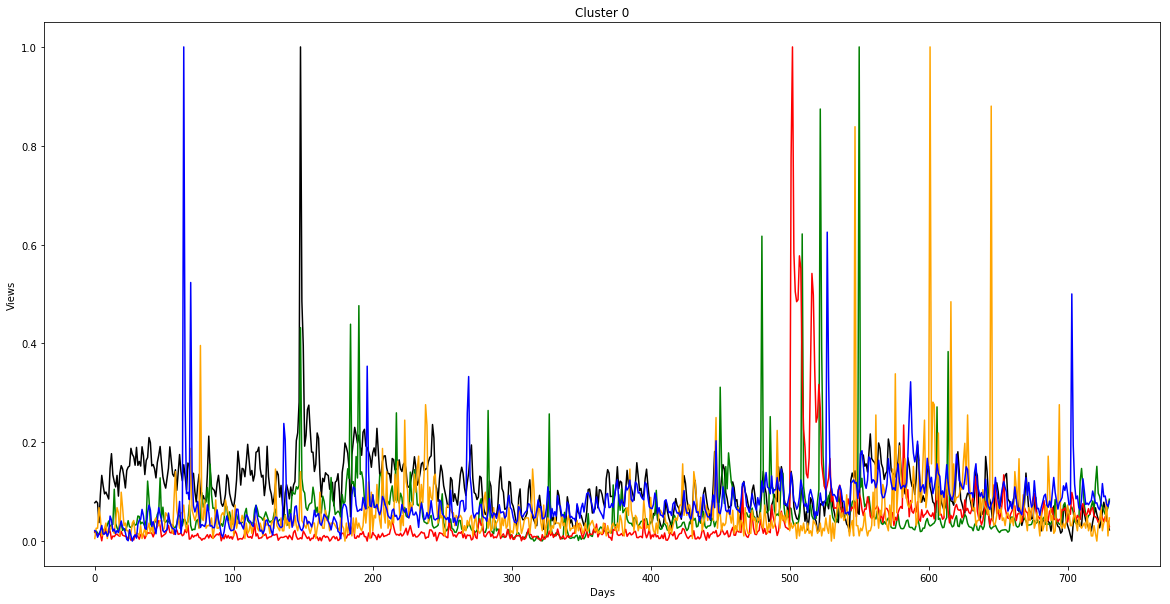

1 => 22


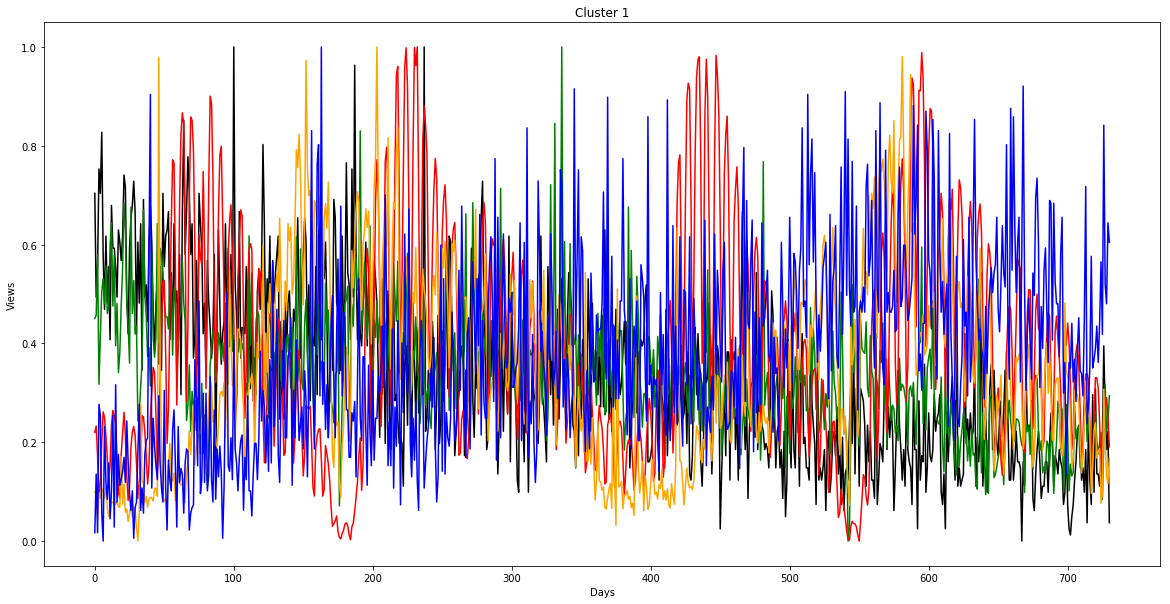

2 => 223


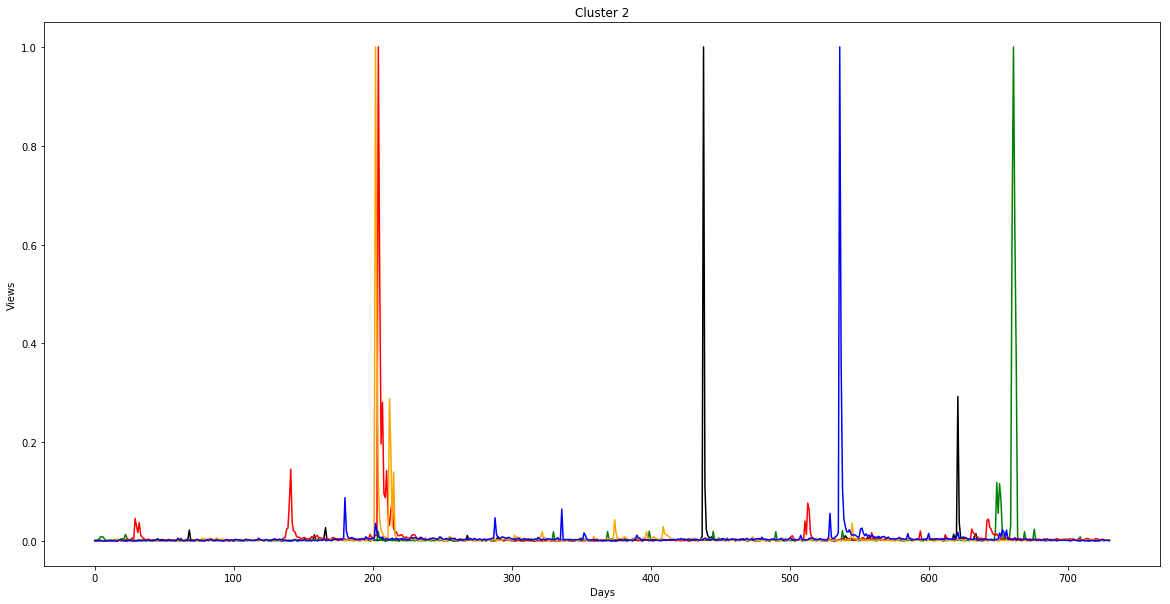

3 => 134


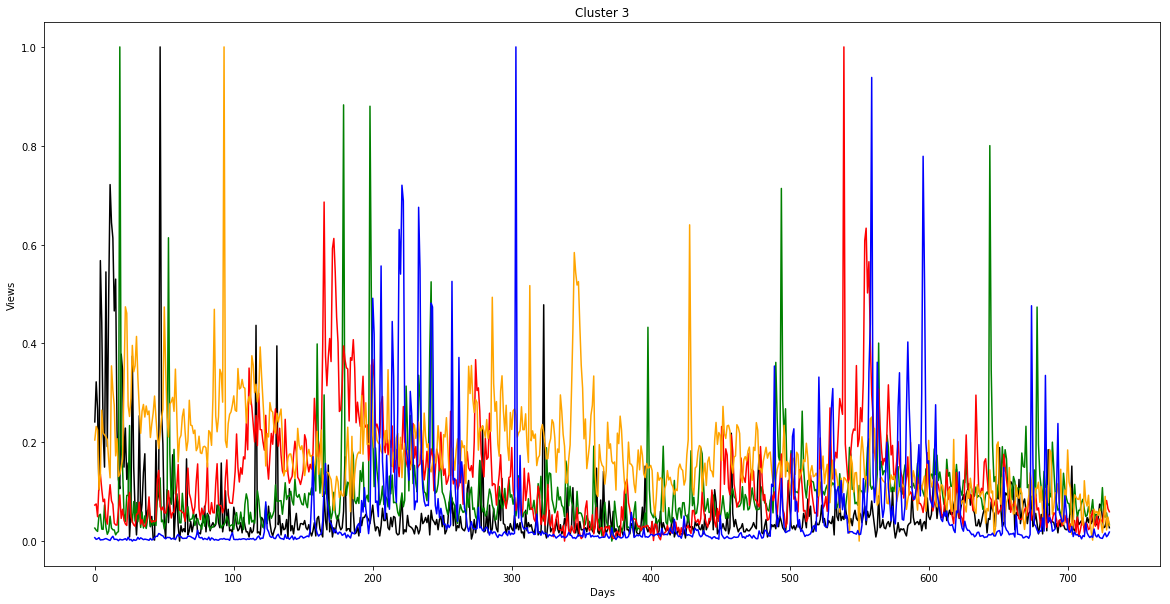

4 => 54


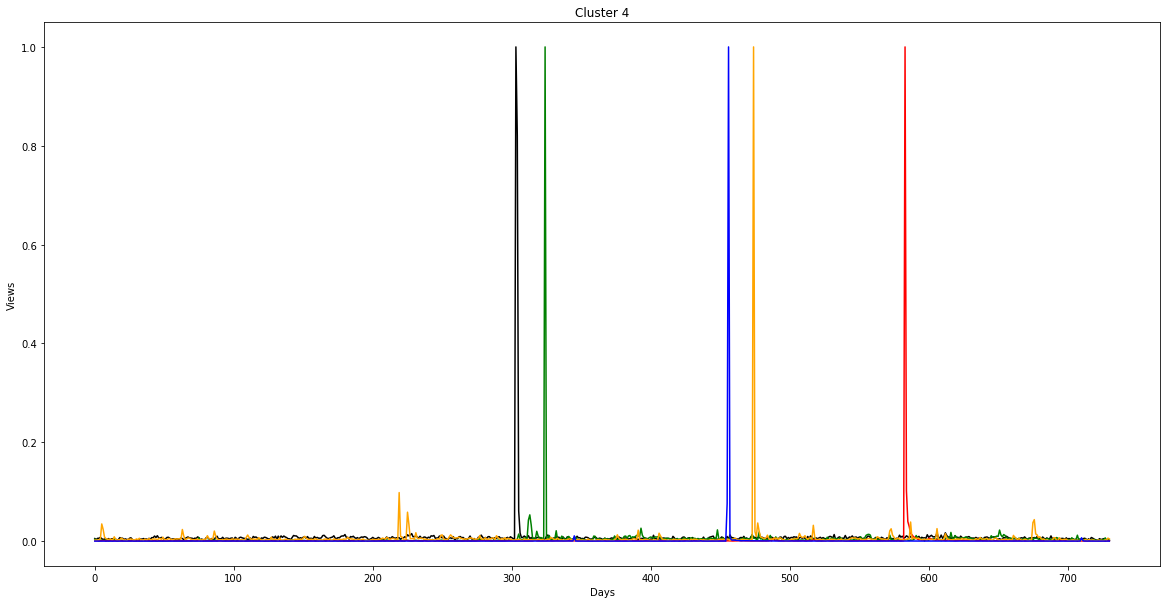

5 => 76


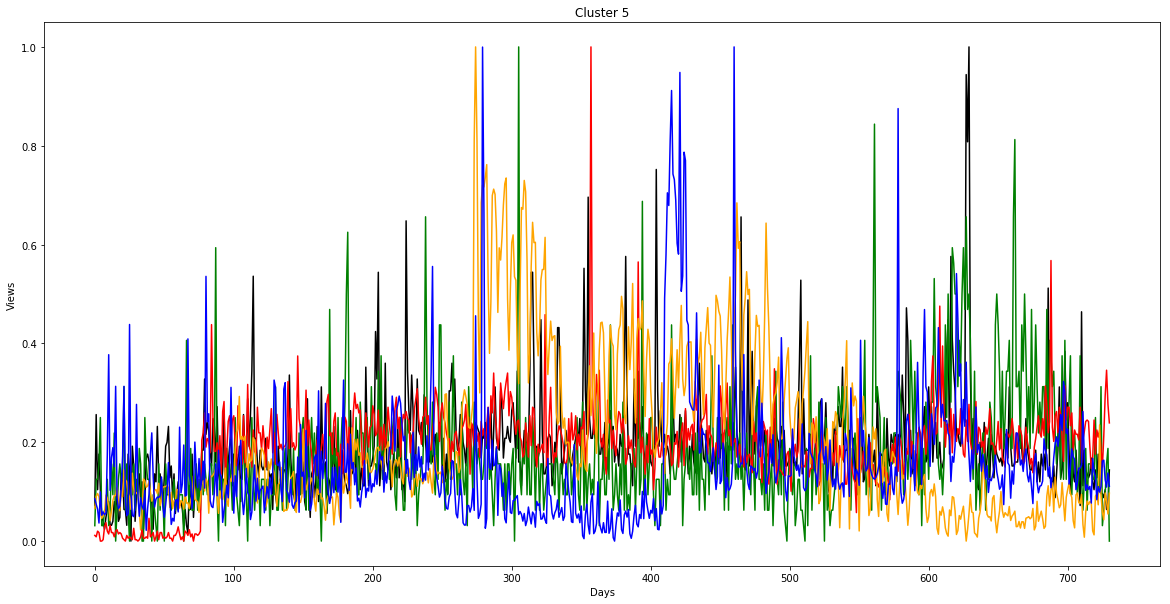

6 => 34


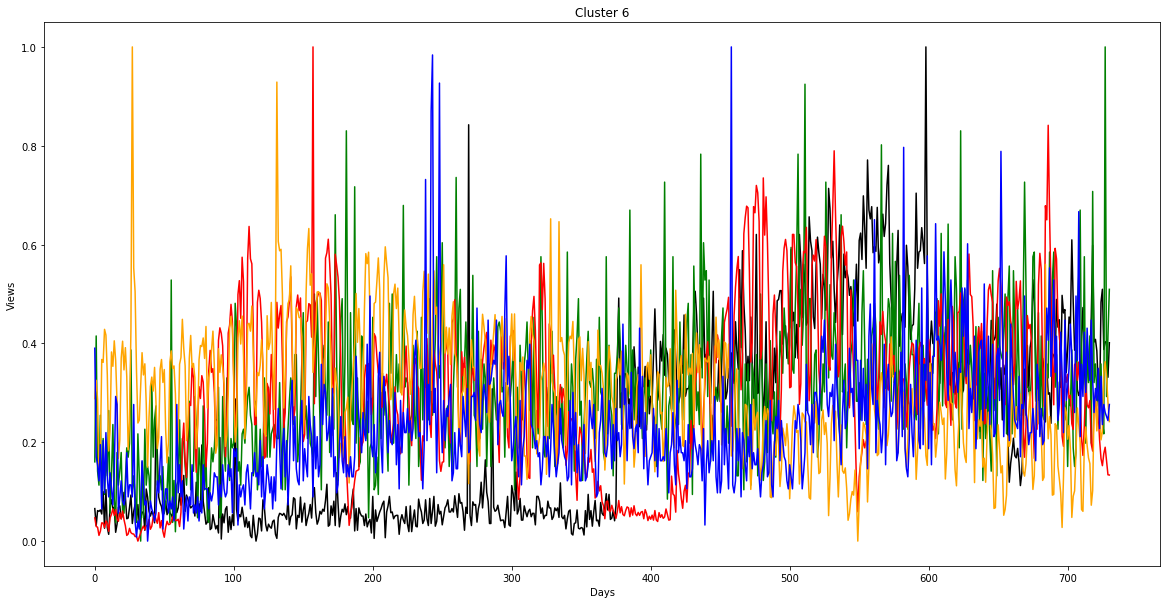

7 => 7


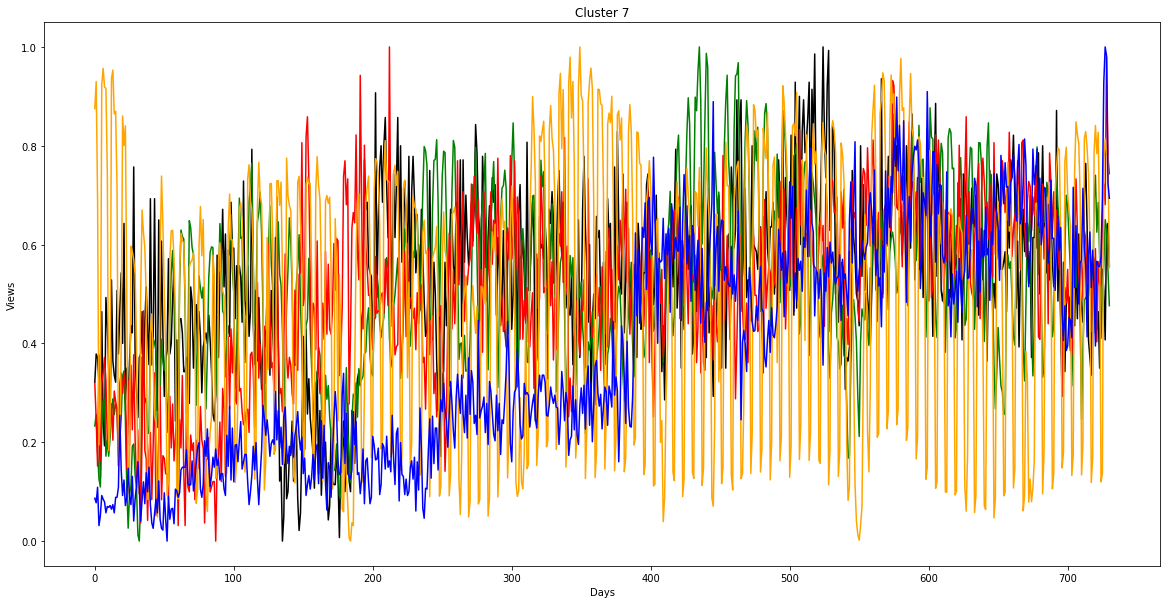

8 => 124


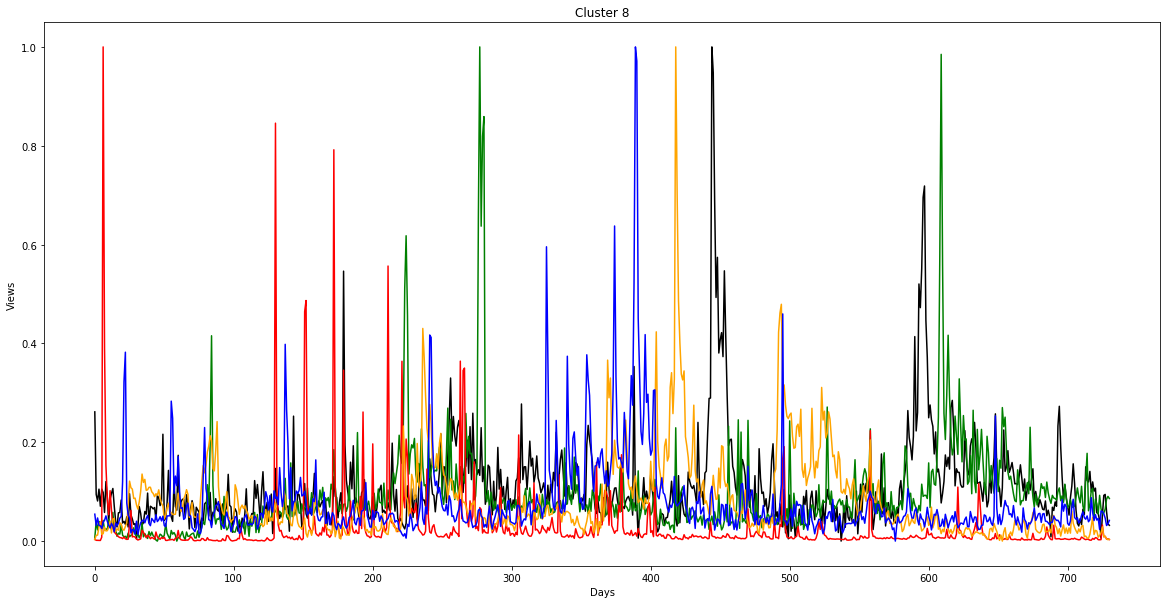

9 => 210


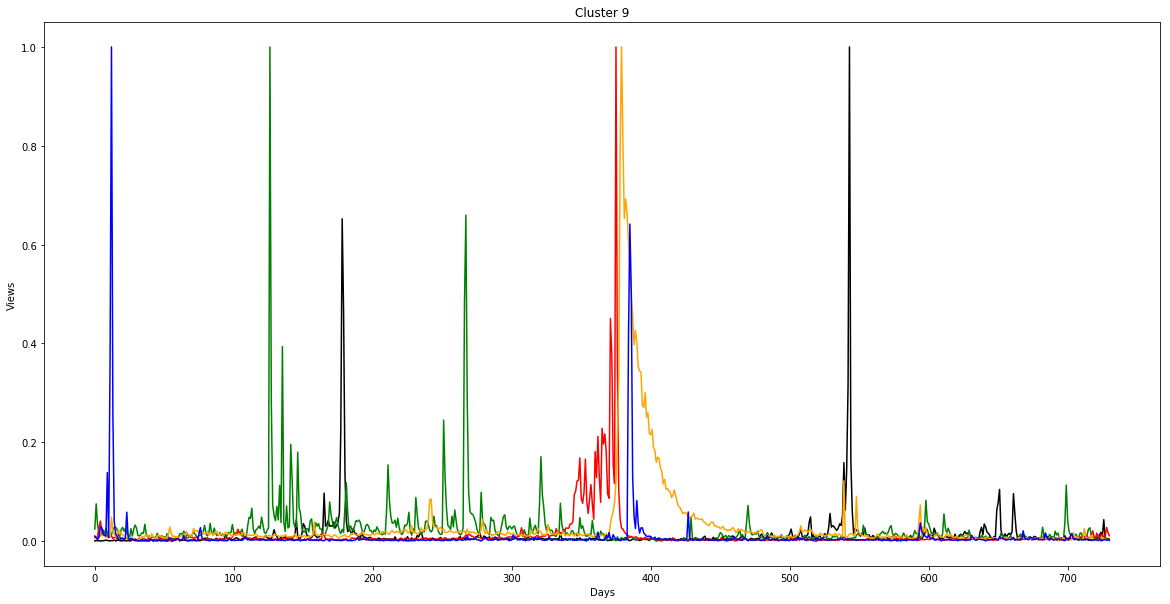

In [26]:
labels = clustering.labels_
labels_unique = np.unique(labels)
for i in labels_unique:
    count = len(labels[labels == i])
    print(f"{i} => {count}")
    plt.figure(figsize=(20,10))
    filtered = dtw_training[labels == i]
    for sample in range(min(count,5)):
        plot_series(filtered.iloc[sample,:],f"Cluster {i}",new_plot=False,plot_show=False,color=colors[sample])
    plt.show()

# BELOW THIS IS OLD CODE, TO BE USED LATER PERHAPS

## Grouping page by language

Here, we split the dataset in datasets for each language, assigned in a dictionary, we also declare `plot_for_lang`, a helper function to plot the values of an index for a specific lang. We test it below by plotting a random index for a random lang.

In [ ]:
sets_by_lang = {}

for lang in meta_dataset['lang'].unique().tolist():
    print(lang)
    sets_by_lang[lang] = meta_dataset[meta_dataset['lang'] == lang]
    sets_by_lang[lang].info()
    
def plot_for_lang(index,lang):
    title = sets_by_lang[lang].iloc[index,0]
    data = sets_by_lang[lang].iloc[index,5:]
    plot_series(data,title)

In [ ]:
key = random.choice(list(sets_by_lang.keys()))
index = random.randint(0,sets_by_lang[key].shape[0])
print(key,index)
plot_for_lang(index,key)

## Aggregating data for languages

We aggregate all pages for a specific language and sum their views by days, so we get one series of the total views for each language.

In [ ]:
sums_by_lang = {}
for key in sets_by_lang:
    sums_by_lang[key] = sets_by_lang[key].iloc[:,5:].sum(axis=0)

In [ ]:
plt.figure(figsize=(20,10))

for key in sums_by_lang:
    plot_series(sums_by_lang[key],"Sums of views by day and country", new_plot=False,plot_show=False,label=key)
plt.show()

## Testing with fbProphet

In [ ]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [ ]:
full_set_prophet = sets_by_lang['es'].iloc[6922,5:]
full_set_prophet = pd.DataFrame({'ds': full_set_prophet.index.values, 'y': full_set_prophet.values})
training_size_prophet = 500
train_prophet = full_set_prophet.iloc[:training_size_prophet,:]
test_prophet = full_set_prophet.iloc[training_size_prophet:,:]

In [ ]:
m_prophet = Prophet()
m_prophet.add_country_holidays(country_name='Spain')
m_prophet.fit(train_prophet)
future_prophet = m_prophet.make_future_dataframe(periods=full_set_prophet.shape[0]-training_size_prophet)
forecast_prophet = m_prophet.predict(future_prophet)
fig = m_prophet.plot(forecast_prophet)
a = add_changepoints_to_plot(fig.gca(), m_prophet, forecast_prophet)

In [ ]:
fig2 = m_prophet.plot_components(forecast_prophet)

In [ ]:
m_prophet_cv = Prophet()
m_prophet_cv.fit(full_set_prophet)
prophet_cv = cross_validation(m_prophet_cv, initial=f'{0.79*full_set_prophet.shape[0]} days', horizon = f'{0.2*full_set_prophet.shape[0]} days')
fig = m_prophet_cv.plot(prophet_cv)
prophet_p = performance_metrics(prophet_cv)
prophet_p.head()

## Testing ARIMA models

In [ ]:
# de 72 is not bad
# na 12127
# es 1508
# fr 904
# na 9413
# en 1276
# en 23897

lang = 'na'
index = 12127
full_set = sets_by_lang[lang].iloc[index,5:]
full_set = pd.DataFrame(full_set)
full_set = full_set.values
training_size = 700
train = full_set[:training_size]
test = full_set[training_size:]

history = [x for x in train]
prediction = []


for timepoint in range(len(test)):
    y =  test[timepoint]
    #forcast value
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    y_hat = output[0]
    print(f"{timepoint + 1}/{len(test)}",end='\r')
    #add it in the list
    prediction.append(y_hat)
    history.append(y_hat)

In [ ]:
plt.figure(figsize=(20,10))
plot_prediction = [x for x in train] + prediction
plt.plot(plot_prediction, color='red', label='prediction')
plt.plot(full_set, label='true value')
# plt.xticks(ticks=np.arange(0,len(full_set),10))
plt.grid(axis='x',which='major')
plt.legend()
plt.show()

In [ ]:
test_np = np.array(test)
pred_np = np.array(prediction)
absolute_diff = np.abs(test_np-pred_np)

plt.figure(figsize=(20,10))
plt.plot(absolute_diff)
plt.xticks(ticks=np.arange(0,len(test)))
plt.grid(axis='x',which='major')
plt.show()

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape(test_np, pred_np)

## Extracting date features for a sample

We will try to extract date features, such as month, day of week to use them to train models. We will also use the [holidays library](https://pypi.org/project/holidays/) to add a flag for holidays in different countries for each date.

In [ ]:
def extract_features(page_views):
    df = pd.DataFrame({'date': page_views.index.values, 'views': page_views.values})
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['holiday_us'] = df['date'].map(lambda x: x in holidays.UnitedStates())
    df['holiday_uk'] = df['date'].map(lambda x: x in holidays.UnitedKingdom()) 
    return df

In [ ]:
index = 1
page = sums_by_lang['en']

page_with_features = extract_features(page)

holidays_days = page_with_features[page_with_features['holiday_us'] == True]
not_holidays_days = page_with_features[page_with_features['holiday_us'] == False]

print(holidays_days['views'].mean())
print(not_holidays_days['views'].mean())

In [ ]:
avg_by_day = []
for day in range(7):
    for_day = page_with_features[page_with_features['day_of_week'] == day]
    avg_by_day.append(for_day['views'].mean())

plt.figure(figsize=(20,10))
plt.plot(avg_by_day)
plt.show()